##### [참고자료]
- https://github.com/lsjsj92/keras_basic/blob/master/7.%20predict_multi_img_with_CNN.ipynb


In [4]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os, warnings, cv2
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/세미(2) 프로젝트/2.데이터

/content/drive/.shortcut-targets-by-id/1iZJ97_6lEv6dD796nV-fw4WzH5bf62Jz/세미(2) 프로젝트/2.데이터


In [9]:
# 파일 이름 읽어오기 (레이블로 사용 가능)
categories = os.listdir()[:8]
print(categories)

['isang', 'jammanbo', 'evee', 'pie', 'squirtle', 'pikachu', 'jiwoo', 'leeseul']




---

# 일반데이터

## 1.데이터 전처리
- resize
- morphologyEx  : 노이즈 제거

In [6]:
# 전역 변수부 
categories = os.listdir()[:-1]
X = []
y = []
err = []

# 메인부
for idx, name in enumerate(tqdm(categories)):

    filepath = './'+ name + '/'
    # 읽어들일 파일 경로 설정
    for path in os.listdir(filepath):

        img = cv2.imread(filepath + path)
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)

            # 노이즈 제거 - GaussianBlur (5, 5) 사용
            
            #blur = cv2.GaussianBlur(img, ksize = (5, 5), sigmaX = 0)
            # 선 따기
            #edged = cv2.Canny(blur, 200, 255)

            X.append(img / 256) #.reshape(128, 128, 3)
            y.append(idx)

        except:
            err.append(filepath + path)
            continue

X = np.array(X)
y = to_categorical(np.array(y))     # 원핫인코딩 수행

print('\n에러:','None' if len(err) == 0 else err)

100%|██████████| 8/8 [00:57<00:00,  7.14s/it]



에러: None


In [7]:
print(y[0])
print(type(y))

[1. 0. 0. 0. 0. 0. 0. 0.]
<class 'numpy.ndarray'>


In [8]:
X.shape, type(X[0]) 

((4000, 128, 128, 3), numpy.ndarray)

## 2.train/test split
- train 데이터로 train/valid split 진행
- train 데이터로 데이터 부풀리기 수행


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = seed
)

In [10]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, y_train, stratify = y_train, test_size = 0.2, random_state = seed
)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,          # randomly rotate images in the range 15 degree
    width_shift_range=0.1,      # randomly shift images horizontally 
    height_shift_range=0.1,     # randomly shift images vertically
    shear_range=0.1,            # 도형의 기울기
    zoom_range=[0.8,1.2],       # 0.8~1.2 배 크기로 임의로 확대/축소
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # randomly flip images
    fill_mode='nearest'         # set mode for filling points outside the input boundaries
)

In [12]:
datagen.fit(X_train)

## 3.모델 정의 및 설정

In [13]:
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam

In [14]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape = X_train.shape[1:], padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                    

In [16]:
os.listdir('./모델저장')

['poketmon_noise_adam1.h5']

In [17]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path = './모델저장/poketmon_adam.h5'
mc1 = ModelCheckpoint(model_path, moniter = 'val_loss', verbose = 1, save_best_only = True)
es1 = EarlyStopping(patience = 15)

In [18]:
hist1 = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_valid, Y_valid), epochs = 100, callbacks=[mc1, es1]
)

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 1.6001 - accuracy: 0.4418
Epoch 1: val_loss improved from inf to 0.80102, saving model to ./모델저장/poketmon_adam.h5
80/80 [==============================] - 22s 130ms/step - loss: 1.6001 - accuracy: 0.4418 - val_loss: 0.8010 - val_accuracy: 0.7297
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.6859
Epoch 2: val_loss improved from 0.80102 to 0.74763, saving model to ./모델저장/poketmon_adam.h5
80/80 [==============================] - 10s 127ms/step - loss: 0.9281 - accuracy: 0.6859 - val_loss: 0.7476 - val_accuracy: 0.7688
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.8237 - accuracy: 0.7258
Epoch 3: val_loss improved from 0.74763 to 0.58117, saving model to ./모델저장/poketmon_adam.h5
80/80 [==============================] - 11s 133ms/step - loss: 0.8237 - accuracy: 0.7258 - val_loss: 0.5812 - val_accuracy: 0.8188
Epoch 4/100
80/80 [============================

In [19]:
xy = (X_train, X_valid, X_test, Y_train, Y_valid, y_test)

np.save("./모델저장/train_valid_test_xy.npy", xy)

# 읽어들일 때는 사용
# X_train, X_test, Y_train, Y_test = np.load('./obj.npy')

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [20]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

25/25 [==============================] - 0s 12ms/step - loss: 0.1852 - accuracy: 0.9488


[0.18516287207603455, 0.9487500190734863]

In [2]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (10, 7))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('Poketmon_adam_no_noise')
plt.legend()
plt.grid(linestyle = ':')

plt.show()

NameError: ignored



---

# 노이즈 제거 데이터

## 1.데이터 전처리
- resize
- morphologyEx  : 노이즈 제거

In [10]:
# 전역 변수부 
categories = os.listdir()[:-1]
X = []
y = []
err = []

# 메인부
for idx, name in enumerate(tqdm(categories)):

    filepath = './'+ name + '/'
    # 읽어들일 파일 경로 설정
    for path in os.listdir(filepath):

        img = cv2.imread(filepath + path)
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)

            # 노이즈 제거 - GaussianBlur (5, 5) 사용
            blur = cv2.GaussianBlur(img, ksize = (5, 5), sigmaX = 0)
            # 선 따기
            #edged = cv2.Canny(blur, 200, 255)

            X.append(blur / 256) #.reshape(128, 128, 3)
            y.append(idx)

        except:
            err.append(filepath + path)
            continue

X_blur = np.array(X)
y_blur = to_categorical(np.array(y))     # 원핫인코딩 수행

print('\n에러:','None' if len(err) == 0 else err)

100%|██████████| 8/8 [01:03<00:00,  7.88s/it]



에러: None


In [11]:
X_blur.shape, type(X_blur[0]) 

((4000, 128, 128, 3), numpy.ndarray)

## 2.train/test split
- train 데이터로 train/valid split 진행
- train 데이터로 데이터 부풀리기 수행


In [12]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_blur, y_blur, test_size = 0.2, stratify = y_blur, random_state = seed
)

In [13]:
X_train2, X_valid2, Y_train2, Y_valid2 = train_test_split(
    X_train2, y_train2, stratify = y_train2, test_size = 0.2, random_state = seed
)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,          # randomly rotate images in the range 15 degree
    width_shift_range=0.1,      # randomly shift images horizontally 
    height_shift_range=0.1,     # randomly shift images vertically
    shear_range=0.1,            # 도형의 기울기
    zoom_range=[0.8,1.2],       # 0.8~1.2 배 크기로 임의로 확대/축소
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # randomly flip images
    fill_mode='nearest'         # set mode for filling points outside the input boundaries
)

In [15]:
datagen.fit(X_train2)

## 3.모델 정의 및 설정

In [16]:
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape = X_train2.shape[1:], padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                    

In [20]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path2 = './모델저장/poketmon_noise_adam.h5'
mc2 = ModelCheckpoint(model_path2, moniter = 'val_loss', verbose = 1, save_best_only = True)
es2 = EarlyStopping(patience = 15)

hist2 = model.fit(
    datagen.flow(X_train2, Y_train2, batch_size=32),
    validation_data=(X_valid2, Y_valid2), epochs = 100, callbacks=[mc2, es2]
)

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 1.7079 - accuracy: 0.3902
Epoch 1: val_loss improved from inf to 0.93176, saving model to ./모델저장/poketmon_noise_adam.h5
80/80 [==============================] - 28s 174ms/step - loss: 1.7079 - accuracy: 0.3902 - val_loss: 0.9318 - val_accuracy: 0.6969
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 0.9822 - accuracy: 0.6793
Epoch 2: val_loss improved from 0.93176 to 0.74268, saving model to ./모델저장/poketmon_noise_adam.h5
80/80 [==============================] - 13s 160ms/step - loss: 0.9822 - accuracy: 0.6793 - val_loss: 0.7427 - val_accuracy: 0.7422
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.7410
Epoch 3: val_loss improved from 0.74268 to 0.63276, saving model to ./모델저장/poketmon_noise_adam.h5
80/80 [==============================] - 11s 138ms/step - loss: 0.8107 - accuracy: 0.7410 - val_loss: 0.6328 - val_accuracy: 0.8109
Epoch 4/100
80/80 [==========

In [21]:
xy2 = (X_train2, X_valid2, X_test2, Y_train2, Y_valid2, y_test2)

np.save("./모델저장/train_valid_test_noise_xy.npy", xy2)

# 읽어들일 때는 사용
# X_train, X_test, Y_train, Y_test = np.load('./obj.npy')

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [22]:
best_model2 = load_model(model_path2)
best_model2.evaluate(X_test2, y_test2)

25/25 [==============================] - 1s 20ms/step - loss: 0.3110 - accuracy: 0.8925


[0.3109648823738098, 0.8924999833106995]

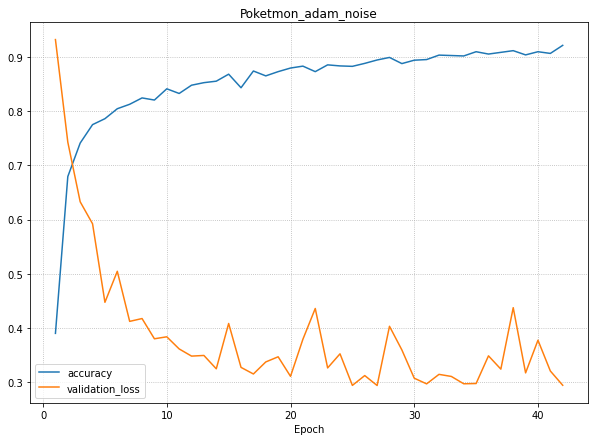

In [23]:
y_acc = hist2.history['accuracy']
y_vloss = hist2.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (10, 7))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('Poketmon_adam_noise')
plt.legend()
plt.grid(linestyle = ':')

plt.show()